In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver

from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
from Problem.LogDataHandling import *
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK75_1"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context,to_csv=True,filename=dataset)
station_coordinates = pd.read_csv('../datasets/{}/{}_coordinates.csv'.format(dataset[:-2],dataset), encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()

# #UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000
# #distance_matrix_here,time_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/{}/".format(dataset[:-2]),dataset)

distance_matrix_here = distance_matrix_here.to_numpy()
time_matrix_here = time_matrix_here.to_numpy()

routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
startNodes = {"UK20_1":[0,6,10,15],"UK25":[0,6,10,15],"UK50":[0,6,10,15,21,35,40],"UK75":[0,6,10,15,21,35,40,60,31,68]}
endNodes = {"UK20_1":[4,20,2,5],"UK25":[4,20,2,5,22],"UK50":[4,20,2,5,32,45,1],"UK75":[4,20,2,5,32,45,1]}

mutation_arange = [np.round(x,2) for x in np.arange(0.1,1,0.2)]

In [3]:
startNodeIndeces = startNodes[dataset[:-2]]
endNodeIndeces = endNodes[dataset[:-2]]
locationNodeIndeces = list((set(range(len(points_coordinate))) - set(startNodeIndeces)) - set(endNodeIndeces))

vehicleData = {"emptyWeights":[3000,5500],"maxLoads":[3650,8500],"fuelEmpty":[12,22.5],"fuelFull":[15,27.5]}


vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,
                                                            routingContext=routingContext,heterogeneousFleet=True)

In [4]:

def plot_drive_time_distribution(data, start_nodes, bar_kwargs={"SA":{"color":"#1f77b4"}, "NSGA-II": {"color":"#ff7f0e"}, "NSGAIII":{"color":"#2ca02c"}, "IBEA":{"color":"#d62728"}, "IBEA-Adaptive":{"color":"#9467bd"}, "LS":{"color":"#8c564b"}, "GA":{"color":"#e377c2"}}):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)
    
    num_bars = len(data)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)
        
    for algorithm_name, offset in zip(data, offsets):
        ax.bar(np.array(range(0,len(data[algorithm_name]["vehicle_drive_times"][0].keys())))+offset, np.mean(data[algorithm_name]["drive_times_list"],axis=0), width=0.2,alpha=0.8,label=r"$\bf{%s}$" % (algorithm_name),align="center")
        plt.xticks(range(0,len(start_nodes)),labels=range(0,len(start_nodes)))
    
    
    
    plt.legend(bbox_to_anchor=(1,1))
    
    return fig, ax

In [5]:
def plot_vehicle_drivetimes(dataframe,parameter_group):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)
    
    dataframe_parameter_group = dataframe.where(dataframe["Parameter Group"] == parameter_group).dropna()
    
    if type(dataframe_parameter_group.vehicle_route_time.iloc[0]) == str:
        dataframe_parameter_group.vehicle_route_time = dataframe_parameter_group.vehicle_route_time.apply(literal_eval)
        
    dataframe_parameter_group["vehicle_amount"] = dataframe_parameter_group.vehicle_route_time.apply(lambda x: len(x))
    
    vehicle_amounts = sorted(dataframe_parameter_group.vehicle_amount.unique())
    num_bars = len(vehicle_amounts)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)
    
    for vehicle_amount,offset in zip(vehicle_amounts,offsets):
        vehicle_amount_df = dataframe_parameter_group.where(dataframe_parameter_group.vehicle_amount == vehicle_amount).dropna()
        
        vehicle_amount_route_times = np.stack(vehicle_amount_df.vehicle_route_time.apply(lambda x: np.sort(x)[::-1]/60).to_numpy())
        vehicle_route_times_mean = np.mean(vehicle_amount_route_times,axis=0)
        plt.bar(np.arange(vehicle_amount) + offset,vehicle_route_times_mean,width=0.2,alpha=0.5,label=r"$\bf{%s}\ Vehicles$" % (vehicle_amount))
    
    plt.ylabel("Drivetime (minutes)")
    plt.xlabel("Vehicles")
    
    plt.legend(bbox_to_anchor=(1,1))
        
    
    

In [6]:
SA_data = pd.read_csv("parameter_data/{}/SA.csv".format(dataset))
GA_data = pd.read_csv("parameter_data/{}/GA.csv".format(dataset))
NSGA2_data = pd.read_csv("parameter_data/{}/NSGA2.csv".format(dataset))
NSGA3_data = pd.read_csv("parameter_data/{}/NSGA3.csv".format(dataset))
UNSGA3_data = pd.read_csv("parameter_data/{}/UNSGA3.csv".format(dataset))
IBEA_data = pd.read_csv("parameter_data/{}/IBEA.csv".format(dataset))


# SA

In [7]:
SA_data = remove_unwanted_mutation_parameter_groups(SA_data)
add_final_fitness_columns(SA_data)
expand_parameter_colums(SA_data)
add_distance_to_origin(SA_data)


In [8]:
SA_optimal_params = SA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["distance_to_origin"]).head(1)
SA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["distance_to_origin"]).head()

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,distance_to_origin
Parameter Group,,,,,
3.0,14.5,435.895943,444.380556,0.7,622.761959
4.0,14.5,440.887782,444.810556,0.9,626.573211
2.0,14.5,460.092457,445.063889,0.5,640.341345
1.0,14.5,484.712365,449.303889,0.3,661.303005
0.0,14.5,564.054252,470.813889,0.1,735.453722


In [9]:
SA_optimal_params = SA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head(1)
SA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head()

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,distance_to_origin
Parameter Group,,,,,
3.0,14.5,435.895943,444.380556,0.7,622.761959
4.0,14.5,440.887782,444.810556,0.9,626.573211
2.0,14.5,460.092457,445.063889,0.5,640.341345
1.0,14.5,484.712365,449.303889,0.3,661.303005
0.0,14.5,564.054252,470.813889,0.1,735.453722


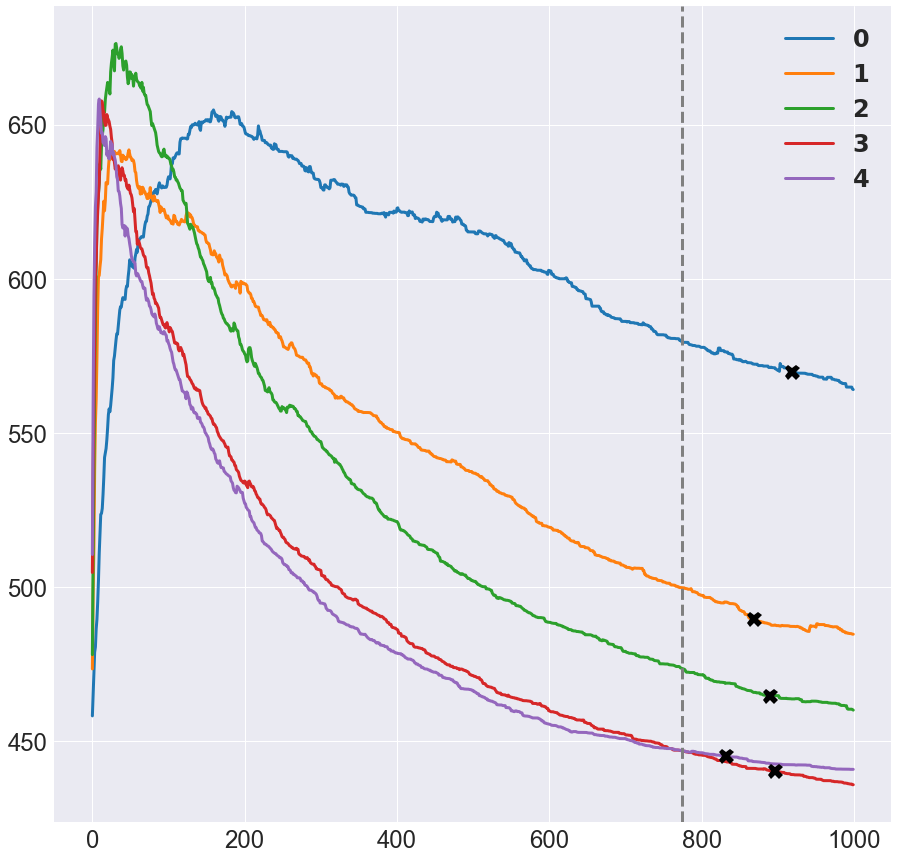

In [10]:
plot_parameter_comparison(SA_data,"fuel_consumption")

# GA

In [11]:
GA_data = remove_unwanted_mutation_parameter_groups(GA_data)
add_final_fitness_columns(GA_data)
expand_parameter_colums(GA_data)
add_distance_to_origin(GA_data)
GA_data_10pop, GA_data_20pop, GA_data_30pop = get_population_size_splits(GA_data)

In [12]:
GA_optimal_params = GA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head(1)
GA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head()

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,distance_to_origin
Parameter Group,,,,,,,
41.0,14.5,421.118672,444.985556,0.9,0.50,30.0,612.851684
38.0,14.5,422.519668,443.783889,0.9,0.25,30.0,612.945324
37.0,14.5,424.409576,444.042778,0.9,0.25,20.0,614.535682
40.0,14.5,427.162352,445.967222,0.9,0.50,20.0,617.733996
44.0,14.5,428.361515,448.167778,0.9,0.75,30.0,620.259548


In [13]:
GA_optimal_params = GA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["distance_to_origin"]).head(1)
GA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["distance_to_origin"]).head()

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,distance_to_origin
Parameter Group,,,,,,,
41.0,14.5,421.118672,444.985556,0.9,0.50,30.0,612.851684
38.0,14.5,422.519668,443.783889,0.9,0.25,30.0,612.945324
37.0,14.5,424.409576,444.042778,0.9,0.25,20.0,614.535682
40.0,14.5,427.162352,445.967222,0.9,0.50,20.0,617.733996
44.0,14.5,428.361515,448.167778,0.9,0.75,30.0,620.259548


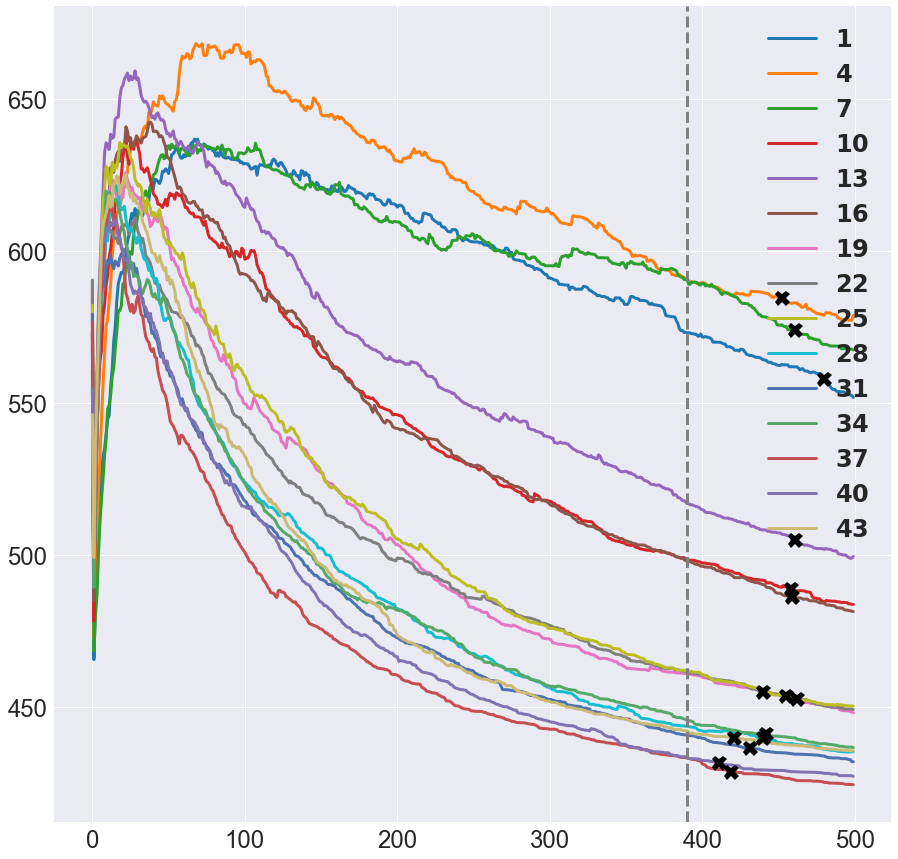

In [14]:
plot_parameter_comparison(GA_data_20pop,"fuel_consumption")

# NSGA-II

In [369]:
NSGA2_data = remove_unwanted_mutation_parameter_groups(NSGA2_data)
add_final_fitness_columns(NSGA2_data)
expand_parameter_colums(NSGA2_data)
add_distance_to_origin(NSGA2_data)
NSGA2_data_10pop, NSGA2_data_20pop, NSGA2_data_30pop = get_population_size_splits(NSGA2_data)

In [370]:
NSGA2_optimal_params = NSGA2_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head(1)
NSGA2_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head()

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,distance_to_origin
Parameter Group,,,,,,,
35.0,14.5,436.685245,443.914444,0.7,0.75,30.0,623.089503
40.0,14.5,441.195225,447.500556,0.9,0.50,20.0,628.839496
43.0,14.5,441.835032,448.576111,0.9,0.75,20.0,630.132080
34.0,14.5,444.008588,446.991667,0.7,0.75,20.0,630.667688
26.0,14.5,444.135619,452.810556,0.5,0.75,30.0,634.861902


In [371]:
NSGA2_optimal_params = NSGA2_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["distance_to_origin"]).head(1)
NSGA2_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["distance_to_origin"]).head()

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,distance_to_origin
Parameter Group,,,,,,,
35.0,14.5,436.685245,443.914444,0.7,0.75,30.0,623.089503
42.0,14.5,446.187310,439.708889,0.9,0.75,10.0,627.169226
40.0,14.5,441.195225,447.500556,0.9,0.50,20.0,628.839496
44.0,14.5,444.903816,444.208333,0.9,0.75,30.0,628.966404
32.0,14.5,445.110612,443.667778,0.7,0.50,30.0,628.989684


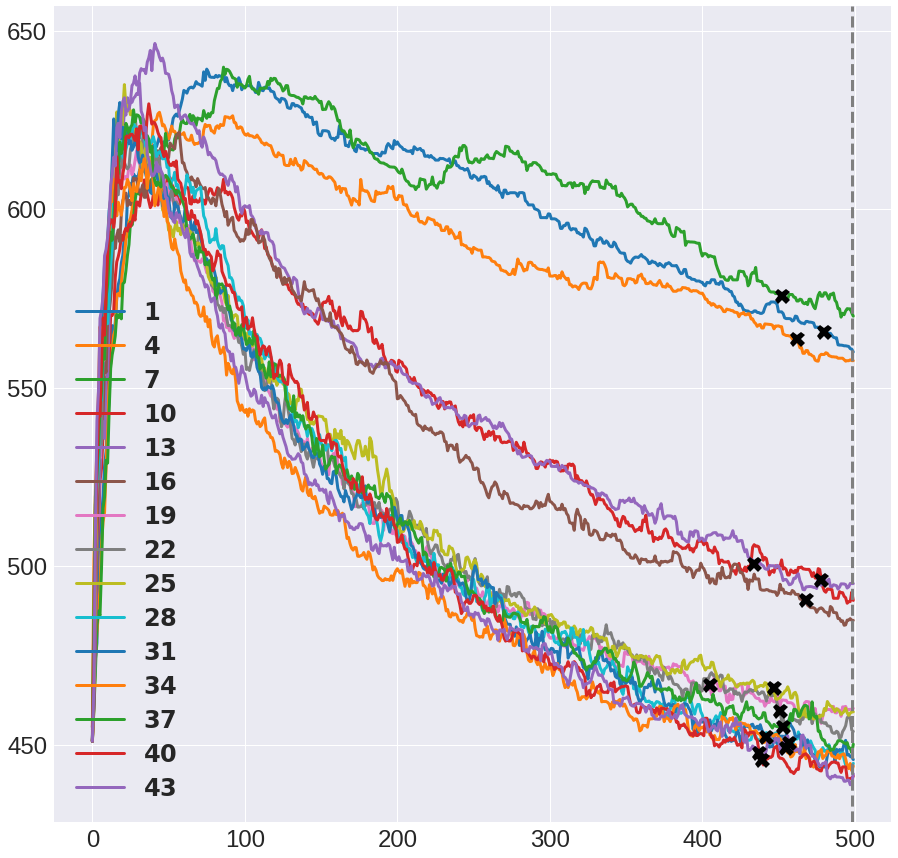

In [372]:
plot_parameter_comparison(NSGA2_data_20pop,"fuel_consumption")

# NSGA-III

In [374]:
NSGA3_data = remove_unwanted_mutation_parameter_groups(NSGA3_data)
add_final_fitness_columns(NSGA3_data)
expand_parameter_colums(NSGA3_data)
add_distance_to_origin(NSGA3_data)
NSGA3_data_10pop, NSGA3_data_20pop, NSGA3_data_30pop = get_population_size_splits(NSGA3_data)


In [375]:
NSGA3_optimal_params = NSGA3_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head(1)
NSGA3_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head()

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,distance_to_origin
Parameter Group,,,,,,,
40.0,14.5,441.700313,442.570000,0.9,0.50,20.0,625.559491
36.0,14.5,442.000488,443.472222,0.9,0.25,10.0,626.544485
34.0,14.5,442.236426,448.193333,0.7,0.75,20.0,630.166133
43.0,14.5,444.563856,442.688333,0.9,0.75,20.0,627.785059
44.0,14.5,445.038455,447.646111,0.9,0.75,30.0,631.671036


In [376]:
NSGA3_optimal_params = NSGA3_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["distance_to_origin"]).head(1)
NSGA3_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["distance_to_origin"]).head()

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,distance_to_origin
Parameter Group,,,,,,,
40.0,14.5,441.700313,442.570000,0.9,0.50,20.0,625.559491
36.0,14.5,442.000488,443.472222,0.9,0.25,10.0,626.544485
31.0,14.5,448.961956,437.335556,0.7,0.50,20.0,627.506844
43.0,14.5,444.563856,442.688333,0.9,0.75,20.0,627.785059
33.0,14.5,450.930821,436.630000,0.7,0.75,10.0,628.258677


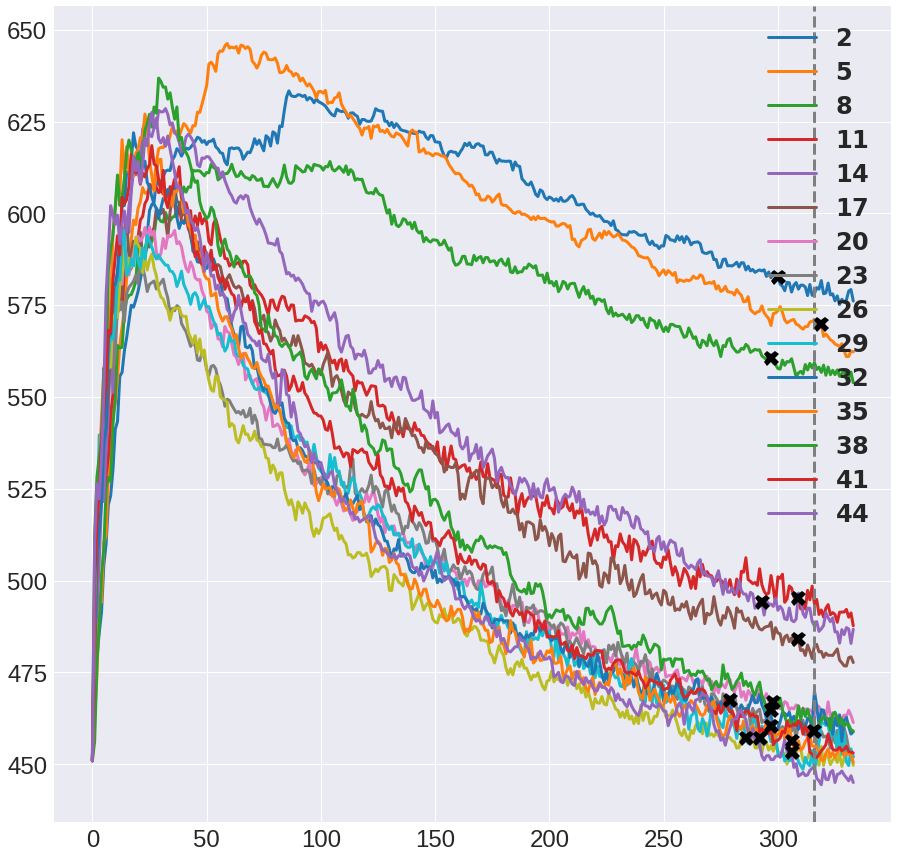

In [382]:
plot_parameter_comparison(NSGA3_data_30pop,"fuel_consumption")

# UNSGA-III

In [377]:
UNSGA3_data = remove_unwanted_mutation_parameter_groups(UNSGA3_data)
add_final_fitness_columns(UNSGA3_data)
expand_parameter_colums(UNSGA3_data)
add_distance_to_origin(UNSGA3_data)
UNSGAIII_data_10pop, UNSGAIII_data_20pop, UNSGAIII_data_30pop = get_population_size_splits(UNSGA3_data)

In [378]:
UNSGA3_optimal_params = UNSGA3_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head(1)
UNSGA3_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head()

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,distance_to_origin
Parameter Group,,,,,,,
35.0,14.5,444.320464,442.155000,0.7,0.75,30.0,627.065478
37.0,14.5,448.584729,450.077778,0.9,0.25,20.0,635.994753
32.0,14.5,449.122966,445.207778,0.7,0.50,30.0,632.834711
40.0,14.5,449.539196,444.592222,0.9,0.50,20.0,632.566607
34.0,14.5,450.569269,435.817778,0.7,0.75,20.0,627.446584


In [379]:
UNSGA3_optimal_params = UNSGA3_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["distance_to_origin"]).head(1)
UNSGA3_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["distance_to_origin"]).head()

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,distance_to_origin
Parameter Group,,,,,,,
35.0,14.5,444.320464,442.155000,0.7,0.75,30.0,627.065478
34.0,14.5,450.569269,435.817778,0.7,0.75,20.0,627.446584
42.0,14.5,450.906490,438.248889,0.9,0.75,10.0,629.346260
44.0,14.5,451.897181,438.291667,0.9,0.75,30.0,629.848270
40.0,14.5,449.539196,444.592222,0.9,0.50,20.0,632.566607


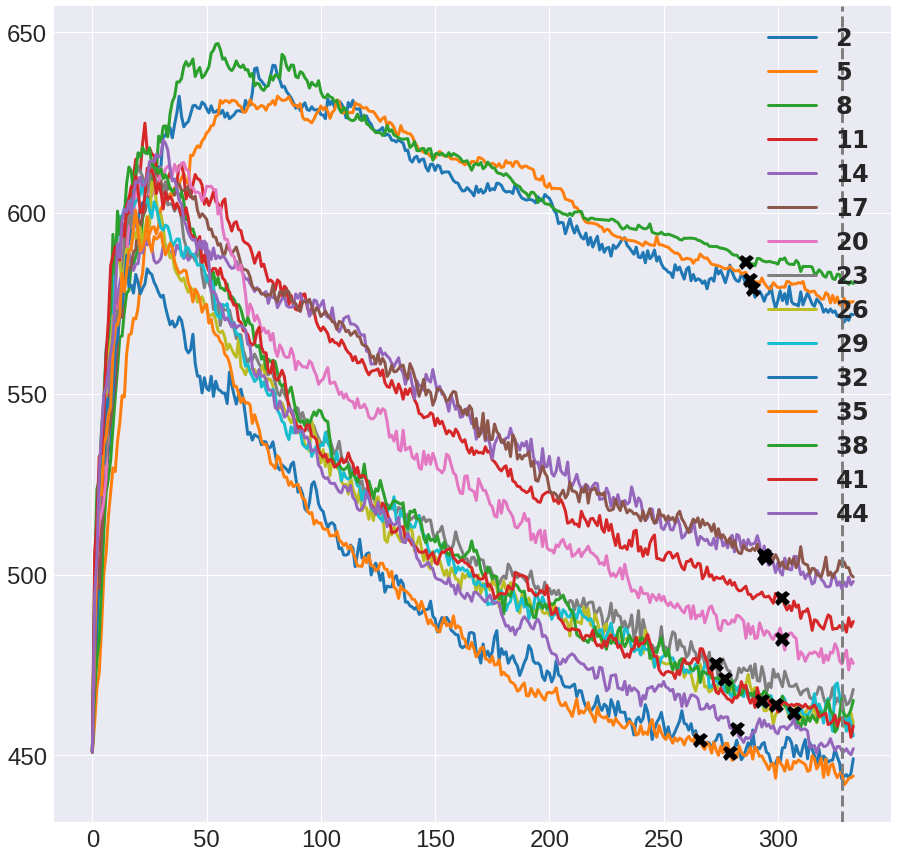

In [353]:
plot_parameter_comparison(UNSGAIII_data_30pop,"fuel_consumption")

# IBEA

In [383]:
IBEA_data = remove_unwanted_mutation_parameter_groups(IBEA_data)
add_final_fitness_columns(IBEA_data)
expand_parameter_colums(IBEA_data)
add_distance_to_origin(IBEA_data)
IBEA_data_10pop, IBEA_data_20pop, IBEA_data_30pop = get_population_size_splits(IBEA_data)

In [401]:
IBEA_optimal_params = IBEA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head(1)
IBEA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head()

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,distance_to_origin
Parameter Group,,,,,,,
43.0,14.5,443.318458,439.090000,0.9,0.75,20.0,624.367482
32.0,14.5,446.579201,434.471667,0.7,0.50,30.0,623.556727
39.0,14.5,450.659639,439.290000,0.9,0.50,10.0,629.734214
31.0,14.5,451.000777,435.835556,0.7,0.50,20.0,627.643636
35.0,14.5,451.754736,436.223333,0.7,0.75,30.0,628.513729


In [402]:
IBEA_optimal_params = IBEA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["distance_to_origin"]).head(1)
IBEA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["distance_to_origin"]).head()

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,distance_to_origin
Parameter Group,,,,,,,
32.0,14.5,446.579201,434.471667,0.7,0.50,30.0,623.556727
43.0,14.5,443.318458,439.090000,0.9,0.75,20.0,624.367482
31.0,14.5,451.000777,435.835556,0.7,0.50,20.0,627.643636
35.0,14.5,451.754736,436.223333,0.7,0.75,30.0,628.513729
39.0,14.5,450.659639,439.290000,0.9,0.50,10.0,629.734214


In [ ]:
plot_vehicle_drivetimes(NSGA2_optimal_params_logs.sort_values(by=["distance_to_origo"]).head(1),31)

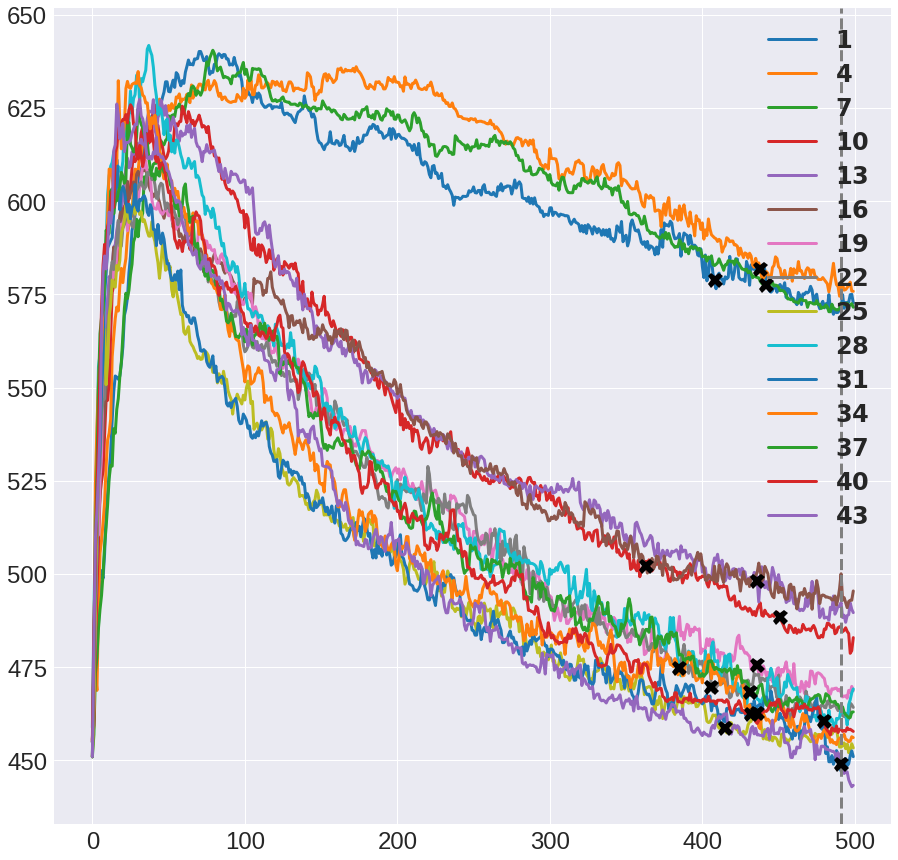

In [400]:
plot_parameter_comparison(IBEA_data_20pop,"fuel_consumption")

# Compare algorithms

In [44]:
SA_optimal_params.iloc[0].name

4.0

In [237]:
SA_optimal_params_logs = SA_data.where(SA_data["Parameter Group"] == SA_optimal_params.iloc[0].name).dropna()
SA_optimal_params_logs["Algorithm"] = "SA"
SA_fuel_consumption = np.mean(np.stack(SA_optimal_params_logs.fuel_consumption.to_numpy()),axis=0)

GA_optimal_params_logs = GA_data.where(GA_data["Parameter Group"] == GA_optimal_params.iloc[0].name).dropna()
GA_optimal_params_logs["Algorithm"] = "GA"
GA_fuel_consumption = np.mean(np.stack(GA_optimal_params_logs.fuel_consumption.to_numpy()),axis=0)

NSGA2_optimal_params_logs = NSGA2_data.where(NSGA2_data["Parameter Group"] == NSGA2_optimal_params.iloc[0].name).dropna()
NSGA2_optimal_params_logs["Algorithm"] = "NSGA2"
NSGA2_fuel_consumption = np.mean(np.stack(NSGA2_optimal_params_logs.fuel_consumption.to_numpy()),axis=0)

NSGA3_optimal_params_logs = NSGA3_data.where(NSGA3_data["Parameter Group"] == NSGA3_optimal_params.iloc[0].name).dropna()
NSGA3_optimal_params_logs["Algorithm"] = "NSGA3"
NSGA3_fuel_consumption = np.mean(np.stack(NSGA3_optimal_params_logs.fuel_consumption.to_numpy()),axis=0)

UNSGA3_optimal_params_logs = UNSGA3_data.where(UNSGA3_data["Parameter Group"] == UNSGA3_optimal_params.iloc[0].name).dropna()
UNSGA3_optimal_params_logs["Algorithm"] = "UNSGA3"
UNSGA3_fuel_consumption = np.mean(np.stack(UNSGA3_optimal_params_logs.fuel_consumption.to_numpy()),axis=0)

IBEA_optimal_params_logs = IBEA_data.where(IBEA_data["Parameter Group"] == IBEA_optimal_params.iloc[0].name).dropna()
IBEA_optimal_params_logs["Algorithm"] = "IBEA"
IBEA_fuel_consumption = np.mean(np.stack(IBEA_optimal_params_logs.fuel_consumption.to_numpy()),axis=0)

In [238]:
NSGA3_optimal_params_logs.fitness = NSGA3_optimal_params_logs.fitness.apply(literal_eval)
NSGA3_optimal_params_logs.computation_times = NSGA3_optimal_params_logs.computation_times.apply(literal_eval)

In [229]:
GA_optimal_params_logs.fitness = GA_optimal_params_logs.fitness.apply(literal_eval)

In [243]:
NSGA3_computation_times = np.stack(NSGA3_optimal_params_logs.computation_times.to_numpy())


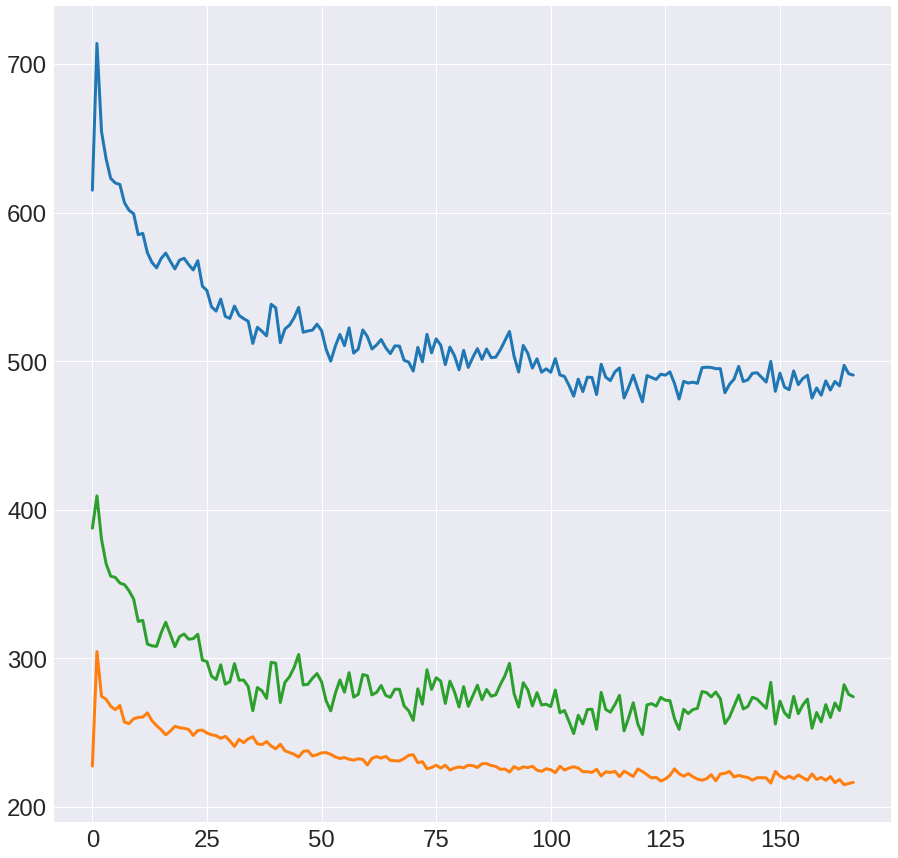

In [231]:
test = np.stack(NSGA3_optimal_params_logs.fitness.to_numpy())

plt.plot(np.mean(np.sum(test,axis=2),axis=0))
plt.plot(np.mean(test,axis=0))

In [232]:
mean_test_fuel = np.mean(test,axis=0)[:,0]
mean_test_drivetime = np.mean(test,axis=0)[:,1]

In [233]:
mean_test_fuel_minmax = (mean_test_fuel - np.min(mean_test_fuel))/(np.max(mean_test_fuel) - np.min(mean_test_fuel)) 
mean_test_drivetime_minmax = (mean_test_drivetime - np.min(mean_test_drivetime))/(np.max(mean_test_drivetime) - np.min(mean_test_drivetime)) 

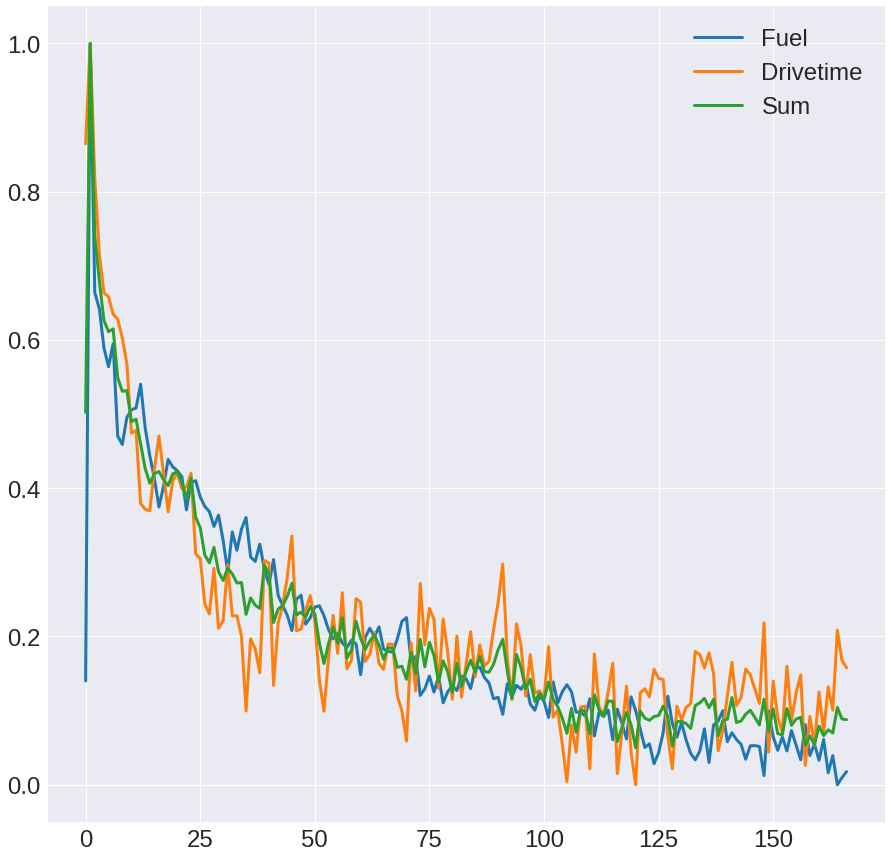

In [259]:
plt.plot(mean_test_fuel_minmax,label="Fuel")
plt.plot(mean_test_drivetime_minmax,label="Drivetime")
plt.plot((mean_test_drivetime_minmax +mean_test_fuel_minmax)/2 ,label="Sum")
plt.legend()
plt.show()

In [46]:
curves= np.array([SA_fuel_consumption,
        GA_fuel_consumption,
        NSGA2_fuel_consumption,
        NSGA3_fuel_consumption,
        UNSGA3_fuel_consumption])#,
        #IBEA_fuel_consumption])

min_length= min([len(x) for x in curves])

for index,curve in enumerate(curves):
    if len(curve) > min_length:
        print(len(curve)/min_length)
        curves[index] = curve[::int(len(curve)/min_length)]
        #print(len(curve)/min_length)

curves = np.stack(curves,axis=0)
lables = ["SA","GA","NSGAII","NSGAIII","UNSGAIII"]


plot_conv_curves(curves,lables)

2.9940119760479043
1.4970059880239521
1.4970059880239521
1.4970059880239521


<ipython-input-46-1bf36a75fffc>:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



ValueError: all input arrays must have the same shape

In [299]:
best_NSGA2 = NSGA2_optimal_params_logs.sort_values(by=["longest_route_time_final","fuel_consumption_final"]).head(1)
best_NSGA2

,Unnamed: 0,fitness,route_distance,fuel_consumption,vehicle_loads,computation_times,vehicle_route_time,violation,paths,Parameter Group,Parameters,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,Algorithm
937,7.0,"[[224.92657892236454, 388.25], [344.0659479932...","[127215, 149872, 155411, 97631, 110273, 188827...","[224.92657892236454, 344.0659479932836, 344.06...","[array([ 0., 602., 603., 537., 141., 825., 81...","[0.01738452911376953, 0.04042387008666992, 0.0...","[10351, 9557, 10117, 8719, 12282, 12325, 11785...","[-221.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[['V0', 42, 33, 30, 34, 19, 29, 2], ['V2', 24,...",31.0,"[('mutation', 0.7), ('crossover', 0.5), ('popu...",212.655191,209.8,0.7,0.5,20.0,NSGA2


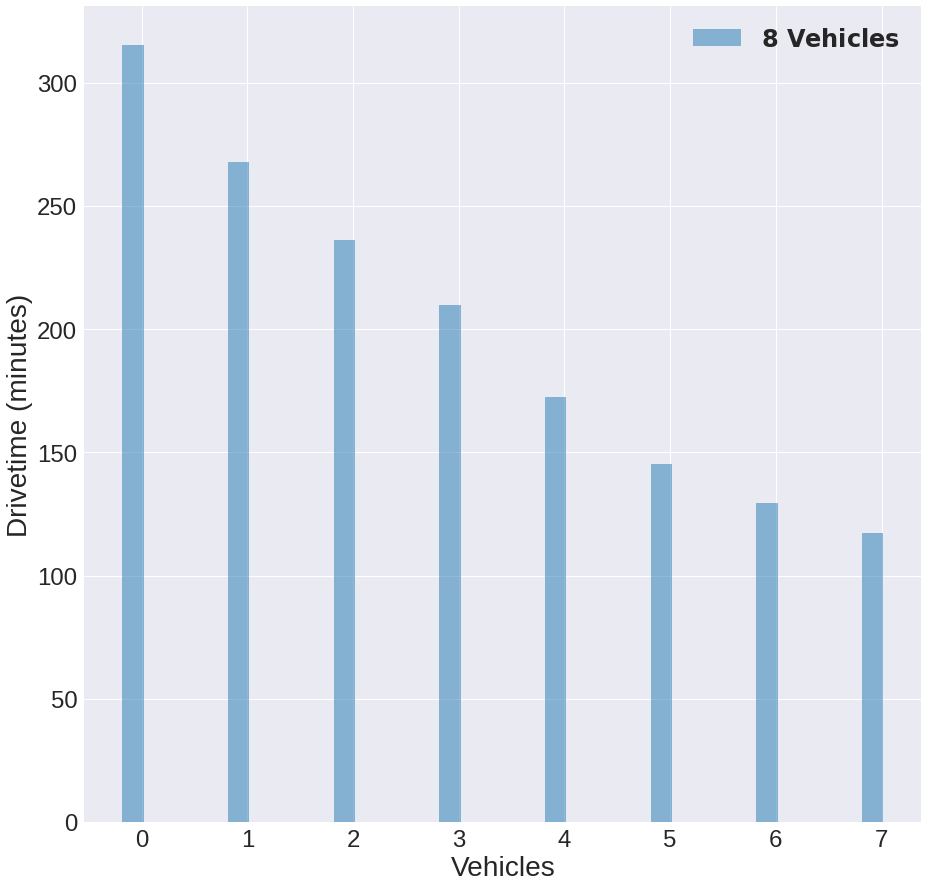

In [281]:
plot_vehicle_drivetimes(best_NSGA2,29)

In [294]:
test3 = NSGA2_optimal_params_logs[["fuel_consumption_final","longest_route_time_final"]]

In [295]:
test3_np = test3.to_numpy()

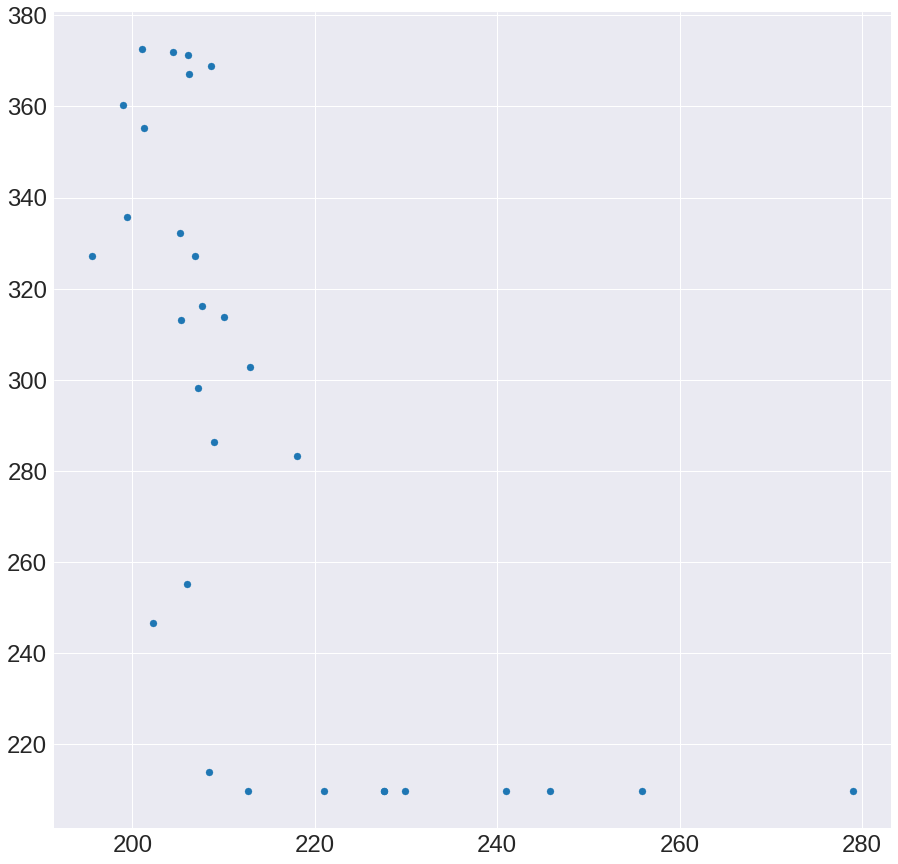

In [296]:
#plt.scatter(test3_np[:,0],test3_np[:,1])

In [304]:
NSGA2_optimal_params_logs["distance_to_origo"] = ((NSGA2_optimal_params_logs.fuel_consumption_final**2) + (NSGA2_optimal_params_logs.longest_route_time_final**2))**0.5

In [308]:
def add_distance_to_origin(dataframe):
    dataframe["distance_to_origin"] = ((dataframe.fuel_consumption_final**2) + (dataframe.longest_route_time_final**2))**0.5

In [309]:
add_distance_to_origin(NSGA2_data)

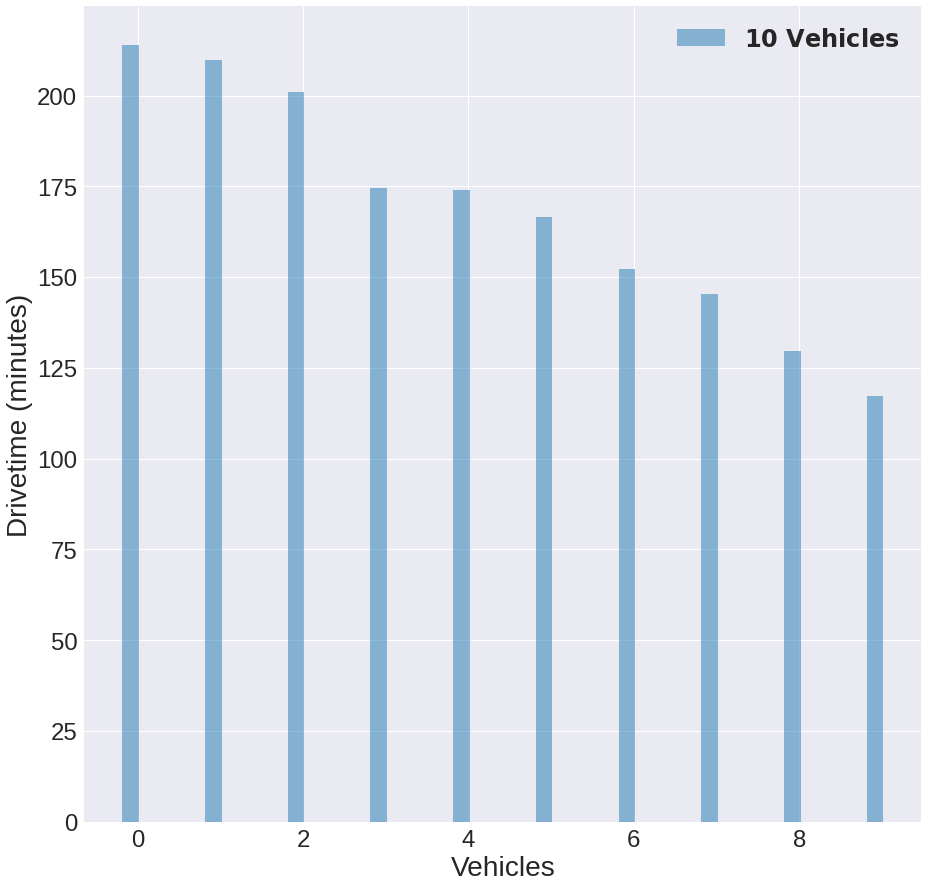

In [307]:
plot_vehicle_drivetimes(NSGA2_optimal_params_logs.sort_values(by=["distance_to_origo"]).head(1),31)

/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



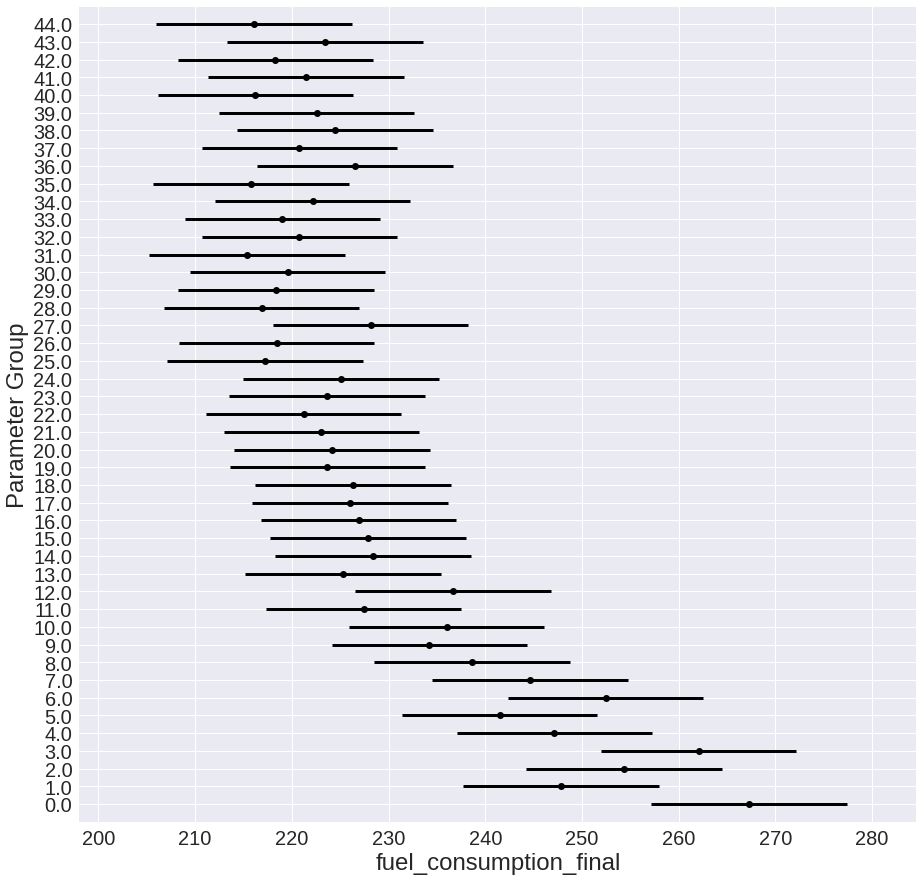

(        group2  meandiff   p-adj    lower    upper  reject
 group1                                                    
 0.0        5.0  -25.7535  0.0010 -45.9732  -5.5339     1.0
 0.0        7.0  -22.6052  0.0083 -42.8249  -2.3855     1.0
 0.0        8.0  -28.5989  0.0010 -48.8186  -8.3793     1.0
 0.0        9.0  -33.0162  0.0010 -53.2359 -12.7965     1.0
 0.0       10.0  -31.2399  0.0010 -51.4596 -11.0202     1.0
 ...        ...       ...     ...      ...      ...     ...
 10.0      35.0  -20.2328  0.0496 -40.4525  -0.0131     1.0
 12.0      31.0  -21.2938  0.0232 -41.5135  -1.0741     1.0
 12.0      35.0  -20.8752  0.0316 -41.0949  -0.6555     1.0
 12.0      40.0  -20.4159  0.0438 -40.6356  -0.1962     1.0
 12.0      44.0  -20.5433  0.0401 -40.7630  -0.3236     1.0
 
 [252 rows x 6 columns],
 <Figure size 1080x1080 with 1 Axes>,
 <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x7f9e9ff06970>)

In [313]:
anova_plot(NSGA2_data,"fuel_consumption_final","Parameter Group")

/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



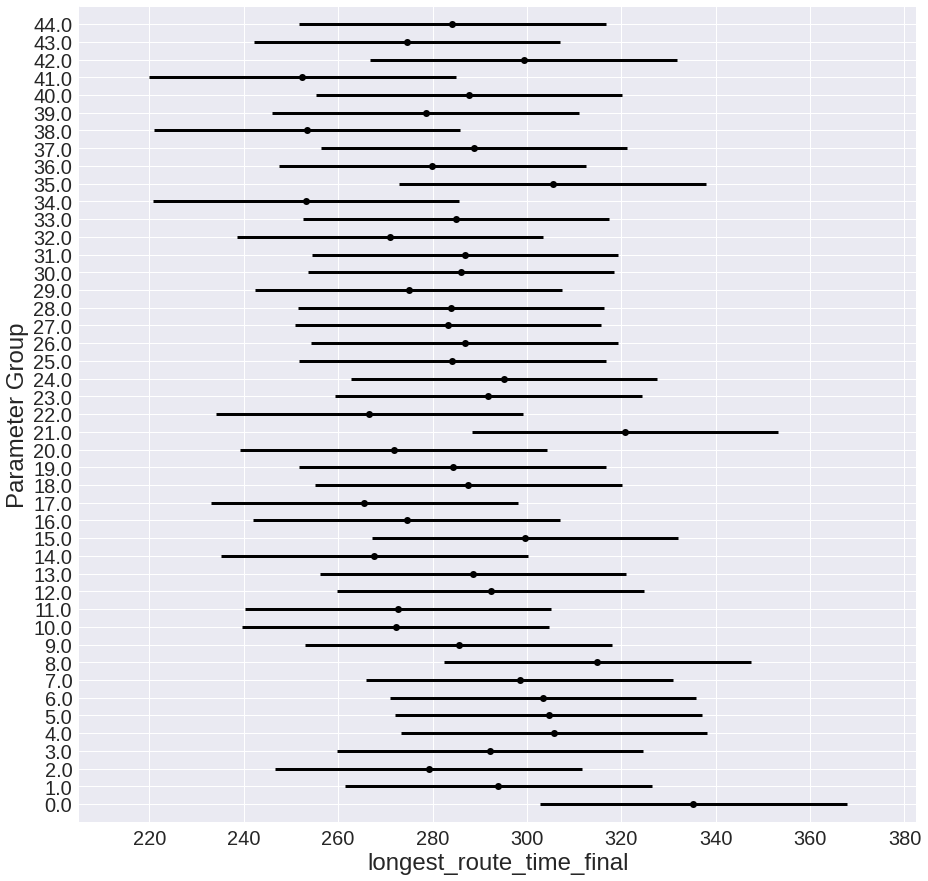

(        group2  meandiff   p-adj     lower    upper  reject
 group1                                                     
 0.0       14.0  -67.5900  0.0280 -132.5378  -2.6422     1.0
 0.0       17.0  -69.7228  0.0170 -134.6706  -4.7750     1.0
 0.0       22.0  -68.6117  0.0221 -133.5595  -3.6638     1.0
 0.0       34.0  -82.1067  0.0010 -147.0545 -17.1588     1.0
 0.0       38.0  -81.8722  0.0010 -146.8200 -16.9244     1.0
 0.0       41.0  -82.8361  0.0010 -147.7839 -17.8883     1.0
 21.0      34.0  -67.6556  0.0275 -132.6034  -2.7077     1.0
 21.0      38.0  -67.4211  0.0291 -132.3689  -2.4733     1.0
 21.0      41.0  -68.3850  0.0233 -133.3328  -3.4372     1.0,
 <Figure size 1080x1080 with 1 Axes>,
 <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x7f9e9dd1cee0>)

In [314]:
anova_plot(NSGA2_data,"longest_route_time_final","Parameter Group")

/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



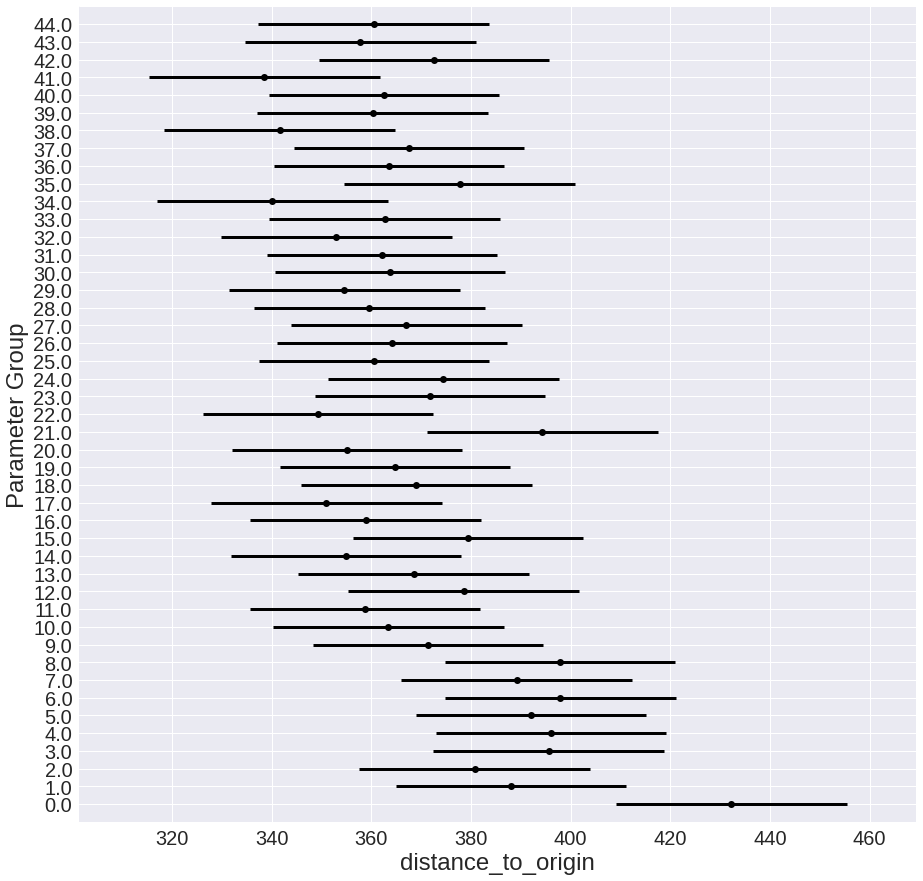

(        group2  meandiff   p-adj     lower    upper  reject
 group1                                                     
 0.0        2.0  -51.4737  0.0091  -97.7511  -5.1964     1.0
 0.0        9.0  -60.8535  0.0010 -107.1309 -14.5761     1.0
 0.0       10.0  -68.8067  0.0010 -115.0840 -22.5293     1.0
 0.0       11.0  -73.4664  0.0010 -119.7438 -27.1890     1.0
 0.0       12.0  -53.6682  0.0041  -99.9455  -7.3908     1.0
 ...        ...       ...     ...       ...      ...     ...
 8.0       38.0  -56.2354  0.0015 -102.5127  -9.9580     1.0
 8.0       41.0  -59.3034  0.0010 -105.5808 -13.0260     1.0
 21.0      34.0  -54.2250  0.0033 -100.5023  -7.9476     1.0
 21.0      38.0  -52.7321  0.0058  -99.0095  -6.4547     1.0
 21.0      41.0  -55.8001  0.0018 -102.0775  -9.5228     1.0
 
 [65 rows x 6 columns],
 <Figure size 1080x1080 with 1 Axes>,
 <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x7f9e9f424bb0>)

In [315]:
anova_plot(NSGA2_data,"distance_to_origin","Parameter Group")

/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



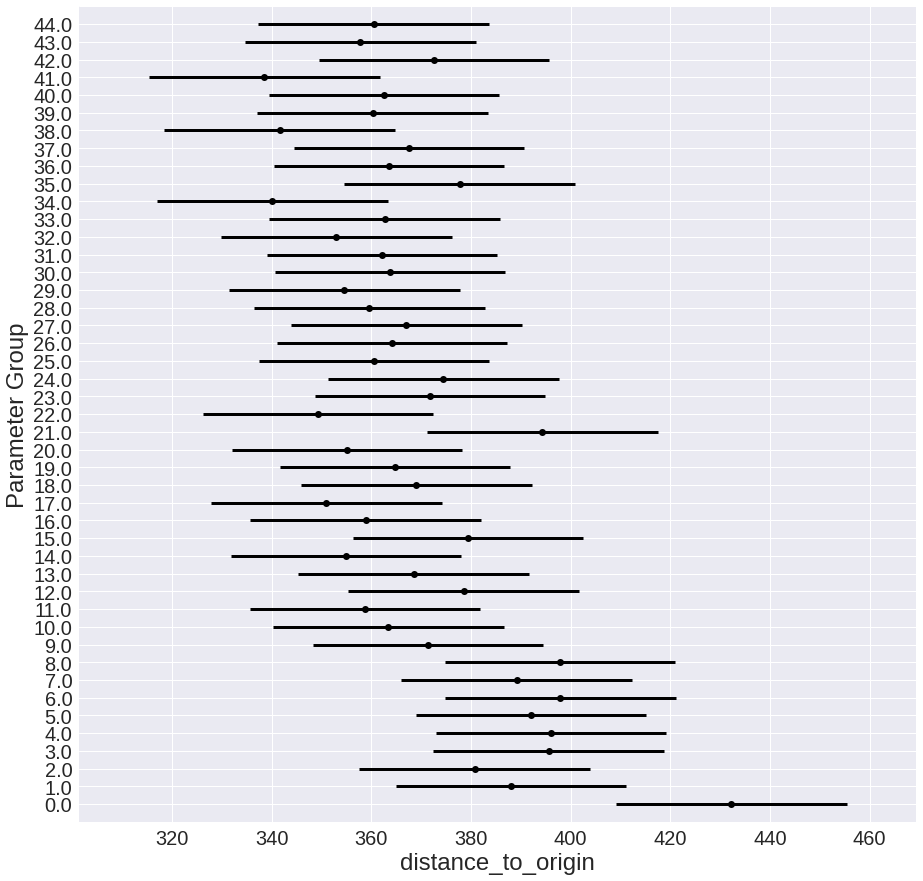

In [319]:
nsga2_data_tukey,fig,_ = anova_plot(NSGA2_data,"distance_to_origin","Parameter Group")
nsga2_data_optimal = extractOptimalParameters(NSGA2_data,nsga2_data_tukey,1)
